# **MLTiming Quickstart**

This notebook is a working example of how to use the MLTiming framework. In this quickstart we calculate the time of flight (TOF) distributions of events from a 22Na source located between two LaBr(Ce) truncated cone detectors. In here we explain how to generate the training dataset from event data, train the models and display the results. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from efficient_kan.src.efficient_kan import KAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import (momentos, create_and_delay_pulse_pair, create_position, 
                       set_seed, calculate_gaussian_center_sigma, normalize, 
                       normalize_given_params, plot_gaussian, get_gaussian_params)
from functions_KAN import train_loop_KAN

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

train_data = np.load(os.path.join(dir,'Na22_train_interpolated.npz'))['data']
val_data = np.load(os.path.join(dir, 'Na22_val_interpolated.npz'))['data']
test_data = np.load(os.path.join(dir, 'Na22_test_val_interpolated.npz'))['data']

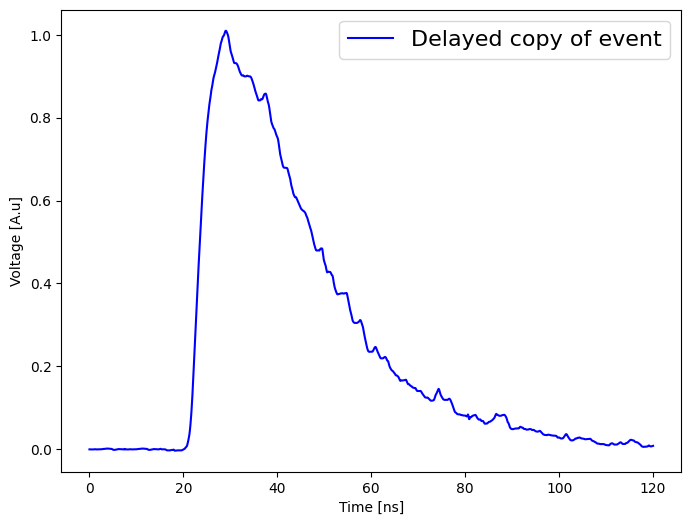

In [4]:
time_step = 0.025
rolled_pulse = np.roll(train_data[0,:,0],300)
rolled_pulse[:300] = train_data[0,:300,0]
time = np.linspace(0,train_data.shape[1]*time_step, train_data.shape[1])

plt.figure(figsize=(8,6))
#plt.plot(time, new_data[0,:,0], 'r', label = 'Original event')
plt.plot(time, rolled_pulse, 'b-', label = 'Delayed copy of event')
plt.legend(prop={'size': 16})
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [A.u]')
plt.savefig('/home/josea/delayed_pulse.png', dpi = 600)

# **IMPORTANT DEFINITIONS**

In [5]:
delay_steps = 30         # Max number of steps to delay pulses
moments_order = 5        # Max order of moments used
set_seed(42)             # Fix seeds
nbins = 91               # Num bins for all histograms
create_positions = 0     # Wether to create new_source positions. (0 = YES, 1 = NO)                           
t_shift = 8              # Time steps to move for the new positions
normalization_method = 'standardization'
start = 400              # Start index to crop the waveform
stop = 592               # Stop index to crop the waveform
epochs = 500             # Number of epochs for training

In [6]:
# Crop Waveform
train_data = train_data[:,start:stop,:] 
validation_data = val_data[:,start:stop,:] 
test_data = test_data[:,start:stop,:]
print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  18000
Número de casos de test:  3075


# **DATASETS**

The 'virtual coincidences' are created using the create_and_delay_pulse_pair functions which takes an array of waveform and creates copies of each event and applies the random delays. Once the 'virtual coincidences' are created one can choose to use the waveforms directly as inputs or calculate input features. In this notebook, we calculate input features using the 'momentos' function. In this example, the different test positions are created by applying an specific delay to the centered position using the 'create position' function. 

In [7]:
# Create Train/Validation/Test set
trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,:,0], time_step, delay_steps = delay_steps, NOISE = False)
trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,:,1], time_step, delay_steps = delay_steps, NOISE = False)

val_dec0, REF_val_dec0 = create_and_delay_pulse_pair(validation_data[:,:,0], time_step, delay_steps = delay_steps, NOISE = False)
val_dec1, REF_val_dec1 = create_and_delay_pulse_pair(validation_data[:,:,1], time_step, delay_steps = delay_steps, NOISE = False)

TEST_00 = test_data  
TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)
TEST = np.concatenate((TEST_02, TEST_00, TEST_20, TEST_04, TEST_40), axis = 0)

# Calculate moments
M_Train_dec0 = momentos(trainX_dec0, order = moments_order) 
M_Train_dec1 = momentos(trainX_dec1, order = moments_order) 

M_Val_dec0 = momentos(val_dec0, order = moments_order) 
M_Val_dec1 = momentos(val_dec1, order = moments_order)

MOMENTS_TEST = momentos(TEST, order = moments_order)

# Normalize moments 
M_Train_dec0, params_dec0 =  normalize(M_Train_dec0, method = normalization_method)
M_Train_dec1, params_dec1 =  normalize(M_Train_dec1, method = normalization_method)

M_Val_dec0_channel0 =  normalize_given_params(M_Val_dec0, params_dec0, channel = 0, method = normalization_method)
M_Val_dec0_channel1 =  normalize_given_params(M_Val_dec0, params_dec0, channel = 1, method = normalization_method)
M_Val_dec0 = np.stack((M_Val_dec0_channel0, M_Val_dec0_channel1), axis = -1)

M_Val_dec1_channel0 =  normalize_given_params(M_Val_dec1, params_dec1, channel = 0, method = normalization_method)
M_Val_dec1_channel1 =  normalize_given_params(M_Val_dec1, params_dec1, channel = 1, method = normalization_method)
M_Val_dec1 = np.stack((M_Val_dec1_channel0, M_Val_dec1_channel1), axis = -1)

MOMENTS_TEST_norm_dec0 = normalize_given_params(MOMENTS_TEST, params_dec0, channel = 0, method = normalization_method)
MOMENTS_TEST_norm_dec1 = normalize_given_params(MOMENTS_TEST, params_dec1, channel = 1, method = normalization_method)
MOMENTS_TEST = np.stack((MOMENTS_TEST_norm_dec0, MOMENTS_TEST_norm_dec1), axis = -1)

/home/josea/.local/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 63 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [8]:
# Create Dataset
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec0).float(), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec1).float(), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)).float())

val_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Val_dec0).float(), torch.from_numpy(np.expand_dims(REF_val_dec0, axis = -1)).float())
val_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Val_dec1).float(), torch.from_numpy(np.expand_dims(REF_val_dec1, axis = -1)).float())

# Create DataLoaders
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

val_loader_dec0 = torch.utils.data.DataLoader(val_dataset_dec0, batch_size = 32, shuffle = True)
val_loader_dec1 = torch.utils.data.DataLoader(val_dataset_dec1, batch_size = 32, shuffle = True)

# **ML MODEL**

In this quickstart notebook we use the KAN architecture. However, MLP and CNN sample implementations are also available in Models.py. Feel free to use different architectures tailored to your needs!

In [9]:
# Define model parameters
architecture = [moments_order, 5, 1, 1]   

# Initialize model
model_dec0 = KAN(architecture)
model_dec1 = KAN(architecture)

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = 5e-3) 
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = 5e-3)  

In [10]:
# Execute train loop
loss_dec0, val_loss_dec0, test_dec0, val_dec0 = train_loop_KAN(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0, torch.tensor(MOMENTS_TEST[:,:,0]).float(), EPOCHS = epochs, name = 'KAN_models/model_dec0', save = False) 
loss_dec1, val_loss_dec1, test_dec1, val_dec1 = train_loop_KAN(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1, torch.tensor(MOMENTS_TEST[:,:,1]).float(), EPOCHS = epochs, name = 'KAN_models/model_dec1', save = False)

EPOCH 1:
LOSS train 0.07351064297402042
LOSS val 0.010311177000403404
EPOCH 2:
LOSS train 0.011659317266950334
LOSS val 0.00973487924784422
EPOCH 3:
LOSS train 0.01018653345851767
LOSS val 0.011010373942553997
EPOCH 4:
LOSS train 0.0132028782189382
LOSS val 0.010203741490840912
EPOCH 5:
LOSS train 0.009288641800326469
LOSS val 0.009572556242346764
EPOCH 6:
LOSS train 0.008593207453898622
LOSS val 0.007908729836344719
EPOCH 7:
LOSS train 0.00795994111300375
LOSS val 0.0064936792477965355
EPOCH 8:
LOSS train 0.007546116365533369
LOSS val 0.008654660545289516
EPOCH 9:
LOSS train 0.012550501886930574
LOSS val 0.0070887040346860886
EPOCH 10:
LOSS train 0.007905452096169784
LOSS val 0.0070362030528485775
EPOCH 11:
LOSS train 0.007049627516908343
LOSS val 0.008038520812988281
EPOCH 12:
LOSS train 0.007129731288239307
LOSS val 0.0064003560692071915
EPOCH 13:
LOSS train 0.006725518369541022
LOSS val 0.006802914198487997
EPOCH 14:
LOSS train 0.00642551724479714
LOSS val 0.007658553775399923
EPOC

# **RESULTS**

The training loop returns directly the estimated time for the test set for detector 0 (test_dec0) and detector 1 (test_dec1) it is advisable to slice this array into the different positions and calculate their TOF separately. Moreover, to perform a global calibration use the 'calculate_gaussian_center_sigma' to get the centroid of on the TOF distributions and use to perform a translation of all the other positions together.

In [11]:
TOFN_V02 = test_dec0[:,:TEST_00.shape[0]] - test_dec1[:,:TEST_00.shape[0]]
TOFN_V00 = test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - test_dec1[:, TEST_00.shape[0] : 2*TEST_00.shape[0]]
TOFN_V20 = test_dec0[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]] - test_dec1[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]]
TOFN_V04 = test_dec0[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]] - test_dec1[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]]
TOFN_V40 = test_dec0[:,4*TEST_00.shape[0]:] - test_dec1[:,4*TEST_00.shape[0]:]
    
# Calculate centered position 'centroid'
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOFN_V00, np.zeros((TOFN_V00.shape[0])), nbins = nbins) 

error_V02 = abs((TOFN_V02 - centroid_V00[:, np.newaxis] + t_shift*time_step))
error_V00 = abs((TOFN_V00 - centroid_V00[:, np.newaxis]))
error_V20 = abs((TOFN_V20 - centroid_V00[:, np.newaxis] - t_shift*time_step))
error_V04 = abs((TOFN_V04 - centroid_V00[:, np.newaxis] + 2*t_shift*time_step))
error_V40 = abs((TOFN_V40 - centroid_V00[:, np.newaxis] - 2*t_shift*time_step))

Error = np.concatenate((error_V02, error_V00, error_V20, error_V04, error_V40), axis = 1)   

You can also plot different metrics' evolutions along the traing process such as coincidence MAE and detectors loss functions.

0.08024935644261112


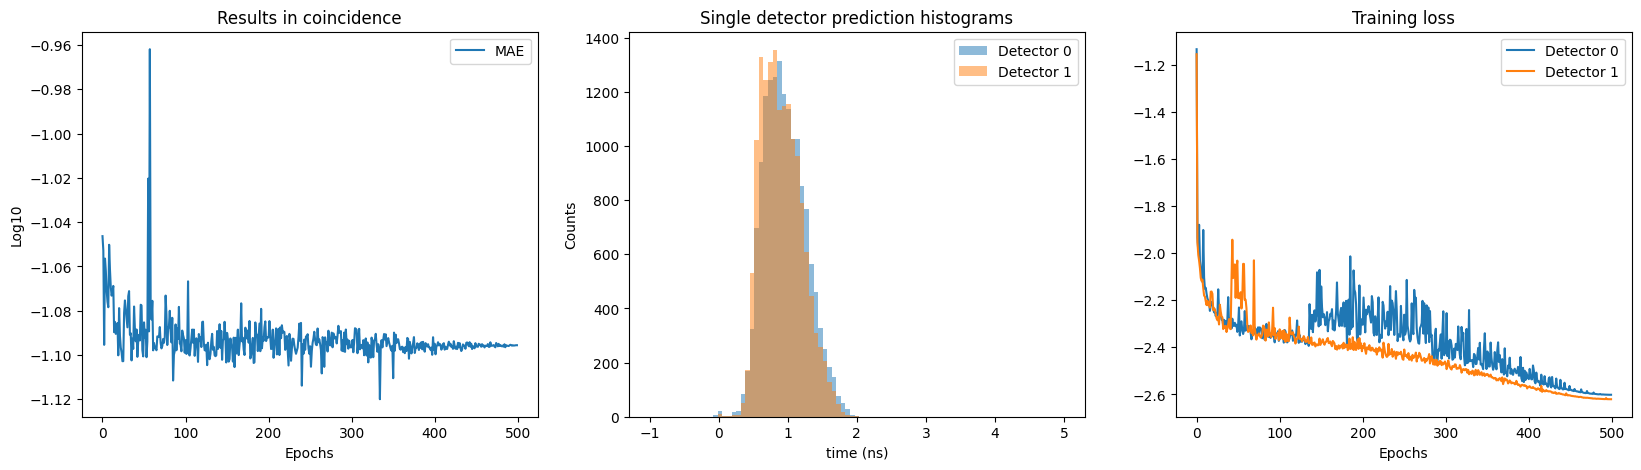

In [12]:
# Print MAE
MAE = np.mean(Error, axis = 1)
print(MAE[-1])

# Plot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(MAE[:].astype('float64')), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
plt.hist(test_dec0[-1, :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 0');
plt.hist(test_dec1[-1, :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 1');

plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()

Plot the final TOF distribution results along their Gaussian fits and parameters.

V40: CENTROID(ns) = 0.400 +/- 0.001  FWHM(ns) = 0.223 +/- 0.001
V20: CENTROID(ns) = 0.200 +/- 0.001  FWHM(ns) = 0.225 +/- 0.001
V00: CENTROID(ns) = 0.000 +/- 0.001  FWHM(ns) = 0.224 +/- 0.001
V02: CENTROID(ns) = -0.199 +/- 0.001  FWHM(ns) = 0.225 +/- 0.001
V04: CENTROID(ns) = -0.399 +/- 0.001  FWHM(ns) = 0.224 +/- 0.001



Text(0, 0.5, 'Counts')

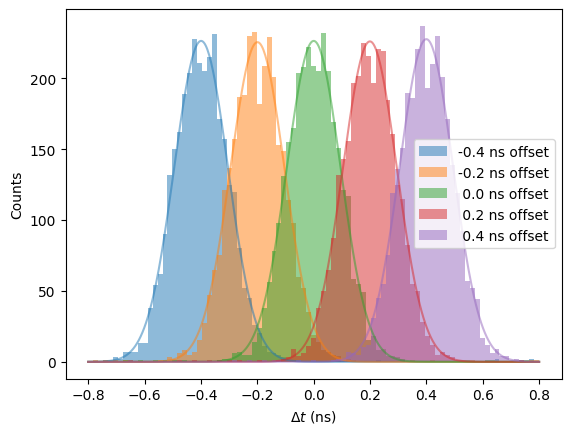

In [13]:
# Histogram and gaussian fit 
plot_gaussian(TOFN_V04[-1,:], centroid_V00[-1], range = 0.8, label = '-0.4 ns offset', nbins = nbins)
plot_gaussian(TOFN_V02[-1,:], centroid_V00[-1], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOFN_V00[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOFN_V20[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
plot_gaussian(TOFN_V40[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.4 ns offset', nbins = nbins)

params_V04, errors_V04 = get_gaussian_params(TOFN_V04[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V02, errors_V02 = get_gaussian_params(TOFN_V02[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOFN_V00[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOFN_V20[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V40, errors_V40 = get_gaussian_params(TOFN_V40[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)

print("V40: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')

0.002500689854821809


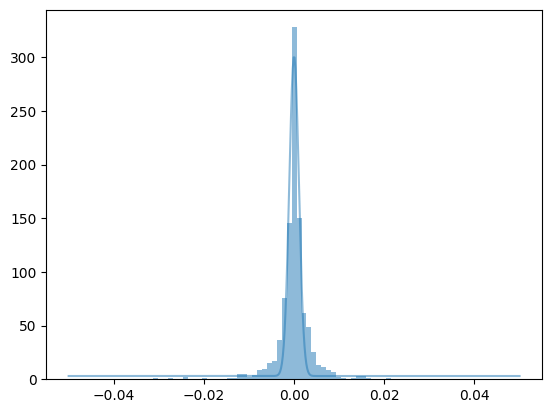

In [14]:
val_dec1 = model_dec1(torch.from_numpy(M_Val_dec1[:,:,0]).float().to(device)) - model_dec1(torch.from_numpy(M_Val_dec1[:,:,1]).float().to(device)) 
err_val = np.squeeze(val_dec1.cpu().detach().numpy()) - REF_val_dec1
plot_gaussian(err_val, np.zeros_like(err_val), range = 0.05, nbins = 91)
params, errors = get_gaussian_params(err_val, np.zeros_like(err_val), range = 0.05, nbins = nbins)
print(params[3])

In [15]:
import time

time_test = np.tile(trainX_dec0[0,:,:], (1000000, 1,1))


time_list_moments = []
# Start timer moments
for i in range(10):
    start_time_momentos = time.time()
    M_time_test = momentos(time_test, order = moments_order)
    end_time_momentos = time.time()
    elapsed_time_momentos = end_time_momentos - start_time_momentos
    time_list_moments.append(elapsed_time_momentos)
time_array_moments = np.array(time_list_moments)

time_list_inference = []
# Start timer inference
for i in range(10):
    start_time_inference= time.time()
    with torch.no_grad():
        assert not torch.is_grad_enabled()
        output_time_test = model_dec0(torch.tensor(M_time_test[:,:,0]).float().to(device))
    end_time_inference = time.time()
    elapsed_time_inference = end_time_inference - start_time_inference
    time_list_inference.append(elapsed_time_inference)
time_array_inference = np.array(time_list_inference)



print('Elapsed time momentos:', np.mean(time_array_moments), np.std(time_array_moments))
print('Elapsed time inference:', np.mean(time_array_inference), np.std(time_array_inference))

Elapsed time momentos: 0.2970071792602539 0.045055480944367336
Elapsed time inference: 0.025882244110107422 0.003917815957314424


Text(0, 0.5, 'Absolute error')

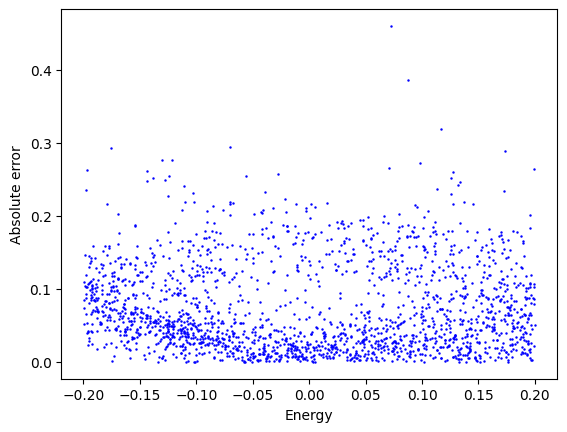

In [16]:
energy_diff = MOMENTS_TEST[:,0,0] - MOMENTS_TEST[:,0,1]

idx = np.where(abs(energy_diff) < 0.2)[0]
plt.plot(energy_diff[idx], Error[-1,idx], 'b.', markersize = 1.5)
plt.xlabel('Energy')
plt.ylabel('Absolute error')

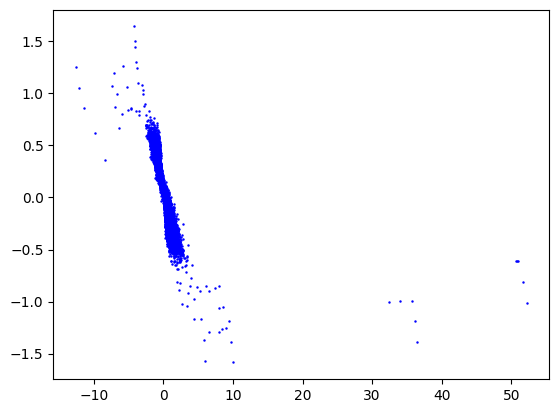

In [17]:
Moment0_diff = MOMENTS_TEST[:,0,0] - MOMENTS_TEST[:,0,1]
plt.plot(Moment0_diff, test_dec0[-1,:]-test_dec1[-1,:], 'b.', markersize = 1.5)